In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTModel

In [2]:
# Mount Google Drive (only for Colab)
drive.mount('/content/drive')

# ========================================================================
# 1. Dataset Configuration
# ========================================================================
dataset_paths = {
    'Normal': '/content/drive/MyDrive/OS Dataset/Normal/',
    'Osteopenia': '/content/drive/MyDrive/OS Dataset/Osteopenia/',
    'Osteoporosis': '/content/drive/MyDrive/OS Dataset/Osteoporosis/'
}

# ========================================================================
# 2. Image Loading & Preprocessing
# ========================================================================
def load_images_and_labels(folder_path, label):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load image and verify successful read
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue

                # Critical Fix 1: Resize to ViT's required 224x224
                img = cv2.resize(img, (224, 224))

                # Critical Fix 2: Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Critical Fix 3: Convert to channels-first format
                img = np.transpose(img, (2, 0, 1))  # (3, 224, 224)

                # Critical Fix 4: Normalize to [-1, 1] range
                img = (img.astype(np.float32) / 127.5) - 1.0

                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels)

# ========================================================================
# 3. Load and Prepare Data
# ========================================================================
# Load datasets
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], 0)
osteopenia_images, osteopenia_labels = load_images_and_labels(dataset_paths['Osteopenia'], label=1)
osteoporosis_images, osteoporosis_labels = load_images_and_labels(dataset_paths['Osteoporosis'], label=2)

# Combine and shuffle data
x_data = np.concatenate([normal_images, osteopenia_images, osteoporosis_images], axis=0)
y_data = np.concatenate([normal_labels, osteopenia_labels, osteoporosis_labels], axis=0)

# Random shuffle with fixed seed for reproducibility
np.random.seed(42)
shuffle_idx = np.random.permutation(len(x_data))
x_data = x_data[shuffle_idx]
y_data = y_data[shuffle_idx]

# ========================================================================
# 4. Train/Validation/Test Split
# ========================================================================
# Stratified split to maintain class balance
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data,
    test_size=0.2,
    stratify=y_data,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.1,  # 10% of training for validation
    stratify=y_train_val,
    random_state=42
)

Mounted at /content/drive


In [3]:
print(f'Number of Normal Images: {len(normal_images)}')
print(f'Number of Oesteopenia Images: {len(osteopenia_images)}')
print(f'Number of Oestroporosis Images: {len(osteoporosis_images)}')

Number of Normal Images: 780
Number of Oesteopenia Images: 374
Number of Oestroporosis Images: 793


In [4]:
# Step 2: Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 3: DWT Implementation
def dwt_haar(img):
    """Performs Haar wavelet transform on a batch of images."""
    # img shape: (batch, channels, height, width)
    batch, channels, h, w = img.shape

    # Split rows into even and odd indices
    even_rows = img[:, :, 0::2, :]
    odd_rows = img[:, :, 1::2, :]

    # Compute row-wise averages and differences
    avg_rows = (even_rows + odd_rows) / 2
    diff_rows = (even_rows - odd_rows) / 2

    # Split columns for avg_rows (LL and HL)
    even_cols_avg = avg_rows[:, :, :, 0::2]
    odd_cols_avg = avg_rows[:, :, :, 1::2]
    LL = (even_cols_avg + odd_cols_avg) / 2
    HL = (even_cols_avg - odd_cols_avg) / 2

    # Split columns for diff_rows (LH and HH)
    even_cols_diff = diff_rows[:, :, :, 0::2]
    odd_cols_diff = diff_rows[:, :, :, 1::2]
    LH = (even_cols_diff + odd_cols_diff) / 2
    HH = (even_cols_diff - odd_cols_diff) / 2

    return torch.cat([LL, HL, LH, HH], dim=1)

# Step 4: Dataset Class (unchanged)
class NumpyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.x_data[idx]).float()
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

Using device: cuda


In [8]:
batch_size = 32
train_dataset = NumpyDataset(x_train, y_train)
val_dataset = NumpyDataset(x_val, y_val)
test_dataset = NumpyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [19]:
# Step 5: Modified ViT Model with DWT Processing (3-class version)
from transformers import SwinModel

# Modified for Swin Transformer
class SwinMultiClassClassifier(nn.Module):
    def __init__(self, pretrained_model='microsoft/swin-base-patch4-window7-224'):
        super().__init__()
        self.swin = SwinModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.swin.config.hidden_size * 4, 3)  # 3 classes

        # Freeze Swin parameters
        for param in self.swin.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Apply Haar DWT (assuming dwt_haar is defined elsewhere)
        x_dwt = dwt_haar(x)
        batch_size = x_dwt.size(0)

        # Reshape and process each subband
        x_dwt = x_dwt.view(batch_size, 4, 3, 112, 112)
        swin_outputs = []

        for i in range(4):
            subband = x_dwt[:, i, :, :, :]
            # Upsample to Swin's expected input size
            subband_up = F.interpolate(subband, size=(224, 224),
                                     mode='bilinear', align_corners=False)
            # Get Swin outputs
            outputs = self.swin(subband_up)
            # Use pooler output instead of CLS token
            swin_outputs.append(outputs.pooler_output)

        # Concatenate and classify
        combined = torch.cat(swin_outputs, dim=1)
        return self.classifier(combined)

# Rest of the code remains similar with model initialization changed to:
model = SwinMultiClassClassifier().to(device)

# Step 8: Loss and Optimizer (3-class compatible)
criterion = nn.CrossEntropyLoss()  # Changed from BCELoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [20]:
# Training loop
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

print(f"\n{'='*50}")
print(f"Starting training with early stopping (patience={patience})")
print(f"and learning rate scheduling (ReduceLROnPlateau)")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    if early_stop:
        print(f"[!] Early stopping triggered at epoch {epoch+1}")
        break

    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_batches += 1

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'AvgLoss': f"{(train_loss/(train_batches*batch_size)):.4f}"
            })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Val]  ") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{(correct/total):.4f}"
                })

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    scheduler.step(epoch_val_loss)

    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

    # Epoch summary
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\nLoaded best model weights for final testing")

# Final evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with tqdm(test_loader, unit="batch", desc="Final Testing") as pbar:
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(test_correct/test_total):.4f}"
            })

print(f"\n{'='*50}")
print(f"Final Test Results:")
print(f"Loss: {test_loss/len(test_dataset):.4f}")
print(f"Accuracy: {test_correct/test_total:.4f}")
print(f"{'='*50}")


Starting training with early stopping (patience=20)
and learning rate scheduling (ReduceLROnPlateau)



Epoch   1/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.6849, Acc=0.6667]



Epoch   1/500 | Train Loss: 0.7688 | Val Loss: 0.7536 | Val Acc: 0.6667 | LR: 1.00e-03


Epoch   2/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5846, Acc=0.7051]



Epoch   2/500 | Train Loss: 0.5864 | Val Loss: 0.7005 | Val Acc: 0.7051 | LR: 1.00e-03


Epoch   3/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.5624, Acc=0.7051]



Epoch   3/500 | Train Loss: 0.5691 | Val Loss: 0.6918 | Val Acc: 0.7051 | LR: 1.00e-03


Epoch   4/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5483, Acc=0.7115]



Epoch   4/500 | Train Loss: 0.5249 | Val Loss: 0.7049 | Val Acc: 0.7115 | LR: 1.00e-03


Epoch   5/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5436, Acc=0.7051]



Epoch   5/500 | Train Loss: 0.5262 | Val Loss: 0.7218 | Val Acc: 0.7051 | LR: 1.00e-03


Epoch   6/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.5601, Acc=0.7244]



Epoch   6/500 | Train Loss: 0.5134 | Val Loss: 0.6645 | Val Acc: 0.7244 | LR: 1.00e-03


Epoch   7/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.6178, Acc=0.6987]



Epoch   7/500 | Train Loss: 0.4956 | Val Loss: 0.6513 | Val Acc: 0.6987 | LR: 1.00e-03


Epoch   8/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5659, Acc=0.7308]



Epoch   8/500 | Train Loss: 0.4716 | Val Loss: 0.6218 | Val Acc: 0.7308 | LR: 1.00e-03


Epoch   9/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5611, Acc=0.7308]



Epoch   9/500 | Train Loss: 0.4519 | Val Loss: 0.6277 | Val Acc: 0.7308 | LR: 1.00e-03


Epoch  10/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.56s/batch, Loss=0.5547, Acc=0.7436]



Epoch  10/500 | Train Loss: 0.4426 | Val Loss: 0.6049 | Val Acc: 0.7436 | LR: 1.00e-03


Epoch  11/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5163, Acc=0.7308]



Epoch  11/500 | Train Loss: 0.4418 | Val Loss: 0.6067 | Val Acc: 0.7308 | LR: 1.00e-03


Epoch  12/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.5144, Acc=0.6987]



Epoch  12/500 | Train Loss: 0.4187 | Val Loss: 0.6873 | Val Acc: 0.6987 | LR: 1.00e-03


Epoch  13/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5243, Acc=0.7244]



Epoch  13/500 | Train Loss: 0.4160 | Val Loss: 0.5986 | Val Acc: 0.7244 | LR: 1.00e-03


Epoch  14/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.5237, Acc=0.7500]



Epoch  14/500 | Train Loss: 0.3890 | Val Loss: 0.5990 | Val Acc: 0.7500 | LR: 1.00e-03


Epoch  15/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5952, Acc=0.7179]



Epoch  15/500 | Train Loss: 0.4139 | Val Loss: 0.6164 | Val Acc: 0.7179 | LR: 1.00e-03


Epoch  16/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.6565, Acc=0.7051]



Epoch  16/500 | Train Loss: 0.4094 | Val Loss: 0.6521 | Val Acc: 0.7051 | LR: 1.00e-03


Epoch  17/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.5058, Acc=0.7564]



Epoch  17/500 | Train Loss: 0.3933 | Val Loss: 0.5820 | Val Acc: 0.7564 | LR: 1.00e-03


Epoch  18/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5186, Acc=0.7372]



Epoch  18/500 | Train Loss: 0.3651 | Val Loss: 0.5641 | Val Acc: 0.7372 | LR: 1.00e-03


Epoch  19/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.4814, Acc=0.7051]



Epoch  19/500 | Train Loss: 0.3716 | Val Loss: 0.6318 | Val Acc: 0.7051 | LR: 1.00e-03


Epoch  20/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5501, Acc=0.7436]



Epoch  20/500 | Train Loss: 0.3892 | Val Loss: 0.6109 | Val Acc: 0.7436 | LR: 1.00e-03


Epoch  21/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5513, Acc=0.7244]



Epoch  21/500 | Train Loss: 0.3747 | Val Loss: 0.6599 | Val Acc: 0.7244 | LR: 1.00e-03


Epoch  22/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5269, Acc=0.7115]



Epoch  22/500 | Train Loss: 0.3495 | Val Loss: 0.6768 | Val Acc: 0.7115 | LR: 1.00e-03


Epoch  23/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4623, Acc=0.7436]



Epoch  23/500 | Train Loss: 0.3525 | Val Loss: 0.5771 | Val Acc: 0.7436 | LR: 1.00e-03


Epoch  24/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.5115, Acc=0.7372]



Epoch  24/500 | Train Loss: 0.3463 | Val Loss: 0.5867 | Val Acc: 0.7372 | LR: 1.00e-03


Epoch  25/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.4976, Acc=0.7500]



Epoch  25/500 | Train Loss: 0.3365 | Val Loss: 0.5896 | Val Acc: 0.7500 | LR: 1.00e-04


Epoch  26/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4895, Acc=0.7436]



Epoch  26/500 | Train Loss: 0.3235 | Val Loss: 0.5807 | Val Acc: 0.7436 | LR: 1.00e-04


Epoch  27/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4914, Acc=0.7372]



Epoch  27/500 | Train Loss: 0.3319 | Val Loss: 0.5728 | Val Acc: 0.7372 | LR: 1.00e-04


Epoch  28/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.56s/batch, Loss=0.4989, Acc=0.7372]



Epoch  28/500 | Train Loss: 0.3275 | Val Loss: 0.5697 | Val Acc: 0.7372 | LR: 1.00e-04


Epoch  29/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.57s/batch, Loss=0.4860, Acc=0.7500]



Epoch  29/500 | Train Loss: 0.3231 | Val Loss: 0.5769 | Val Acc: 0.7500 | LR: 1.00e-04


Epoch  30/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4848, Acc=0.7500]



Epoch  30/500 | Train Loss: 0.3232 | Val Loss: 0.5759 | Val Acc: 0.7500 | LR: 1.00e-04


Epoch  31/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4850, Acc=0.7436]



Epoch  31/500 | Train Loss: 0.3277 | Val Loss: 0.5721 | Val Acc: 0.7436 | LR: 1.00e-05


Epoch  32/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4854, Acc=0.7436]



Epoch  32/500 | Train Loss: 0.3190 | Val Loss: 0.5717 | Val Acc: 0.7436 | LR: 1.00e-05


Epoch  33/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4861, Acc=0.7436]



Epoch  33/500 | Train Loss: 0.3200 | Val Loss: 0.5716 | Val Acc: 0.7436 | LR: 1.00e-05


Epoch  34/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.4854, Acc=0.7436]



Epoch  34/500 | Train Loss: 0.3234 | Val Loss: 0.5716 | Val Acc: 0.7436 | LR: 1.00e-05


Epoch  35/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4854, Acc=0.7436]



Epoch  35/500 | Train Loss: 0.3186 | Val Loss: 0.5718 | Val Acc: 0.7436 | LR: 1.00e-05


Epoch  36/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.55s/batch, Loss=0.4853, Acc=0.7436]



Epoch  36/500 | Train Loss: 0.3098 | Val Loss: 0.5705 | Val Acc: 0.7436 | LR: 1.00e-05


Epoch  37/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4855, Acc=0.7436]



Epoch  37/500 | Train Loss: 0.3224 | Val Loss: 0.5705 | Val Acc: 0.7436 | LR: 1.00e-06


Epoch  38/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4855, Acc=0.7436]
<ipython-input-20-1d24197773d9>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu


Epoch  38/500 | Train Loss: 0.3187 | Val Loss: 0.5706 | Val Acc: 0.7436 | LR: 1.00e-06
[!] Early stopping triggered at epoch 39

Loaded best model weights for final testing


Final Testing: 100%|██████████| 13/13 [00:18<00:00,  1.43s/batch, Loss=1.2881, Acc=0.7872]


Final Test Results:
Loss: 0.5164
Accuracy: 0.7872


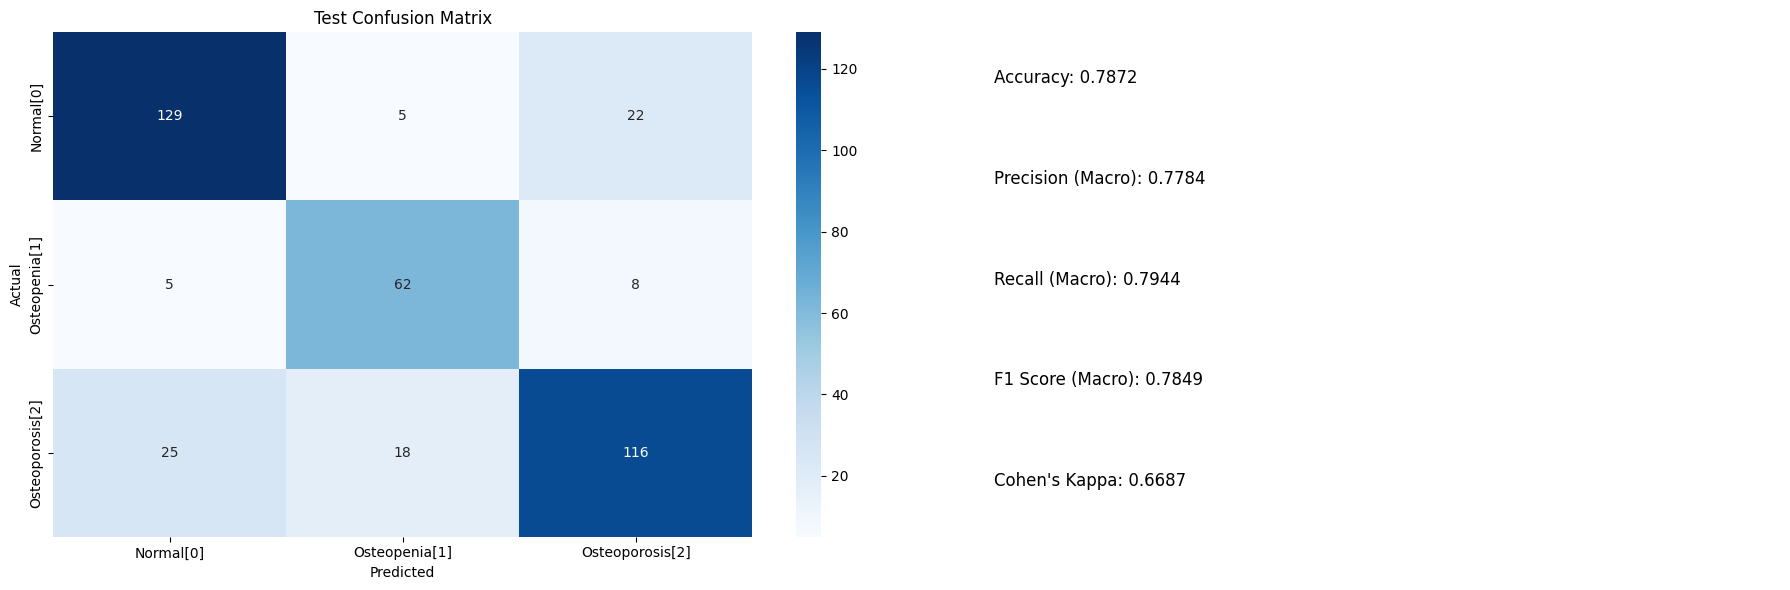

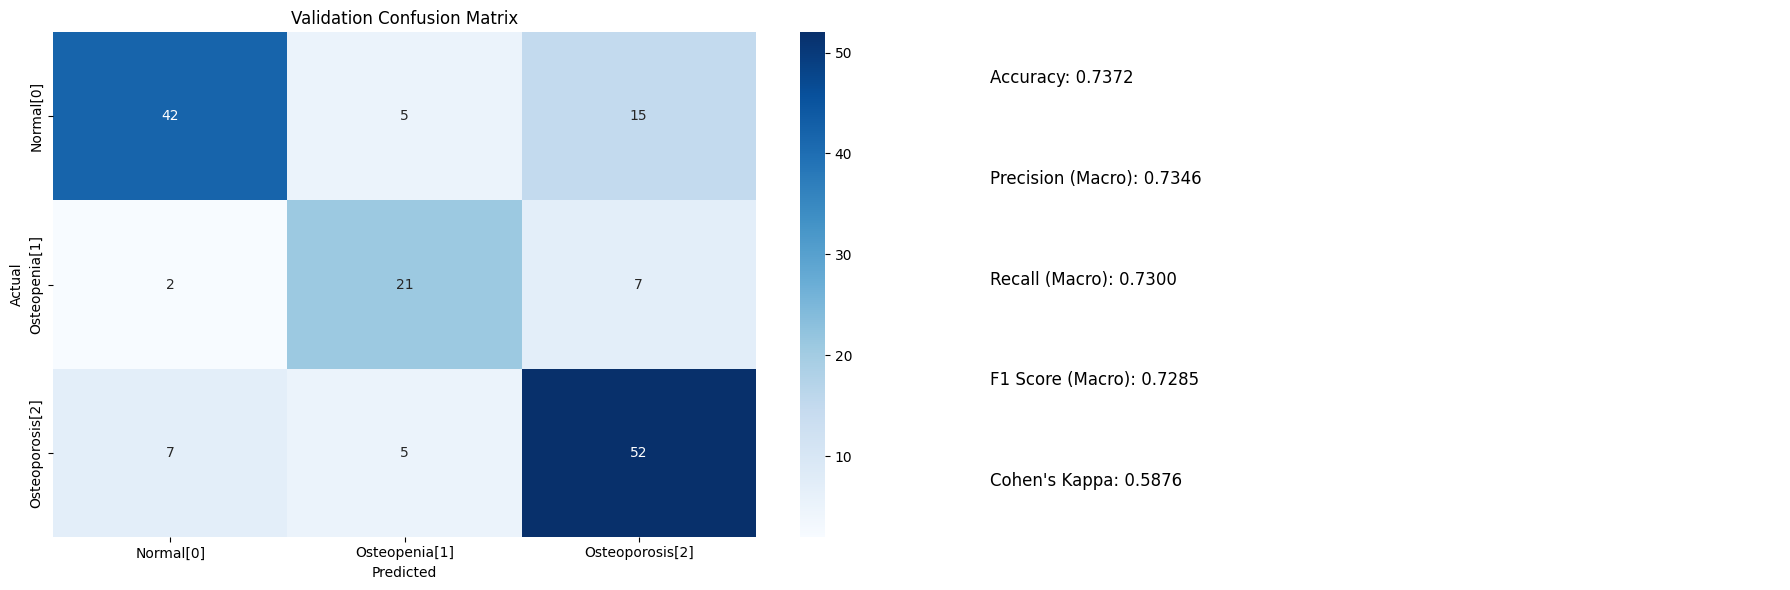

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(18, 6))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal[0]', 'Osteopenia[1]', 'Osteoporosis[2]'],
                yticklabels=['Normal[0]', 'Osteopenia[1]', 'Osteoporosis[2]'])
    plt.title(f'{phase_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision (Macro): {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall (Macro): {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score (Macro): {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Cohen's Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get class predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy

# Evaluate all sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')